In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('happiness_clean_2015_2019_20251110_190504.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   country                  617 non-null    object 
 1   year                     617 non-null    int64  
 2   happiness_score          617 non-null    float64
 3   gdp_per_capita           617 non-null    float64
 4   social_support           617 non-null    float64
 5   healthy_life_expectancy  617 non-null    float64
 6   freedom                  617 non-null    float64
 7   generosity               617 non-null    float64
 8   corruption               617 non-null    float64
 9   rank                     617 non-null    float64
 10  region                   306 non-null    object 
dtypes: float64(8), int64(1), object(2)
memory usage: 53.2+ KB


In [2]:
target = 'happiness_score'
predictors = [
    'gdp_per_capita',
    'social_support',
    'healthy_life_expectancy',
    'freedom',
    'generosity',
    'corruption'
]
df['gdp_per_capita_sq'] = df['gdp_per_capita'] ** 2

df['gdp_x_corruption'] = df['gdp_per_capita'] * df['corruption']
df['gdp_x_social'] = df['gdp_per_capita'] * df['social_support']

cols_needed = [target] + predictors + ['gdp_per_capita_sq', 'gdp_x_corruption', 'gdp_x_social']
df = df[cols_needed]


In [ ]:
# from PHASE 6: Model Selection & Cross-Validation, M5, M6 and M7 are the best models
# Fitting LASSO Model

from statsmodels.tools.eval_measures import rmse
from sklearn.model_selection import KFold
import statsmodels.formula.api as smf
import numpy as np

models = [
    # M1 Baseline: GDP only
    "happiness_score ~ gdp_per_capita",

    # M2 Non-linear GDP (diminishing returns)
    "happiness_score ~ gdp_per_capita + gdp_per_capita_sq",

    # M3 Core 3 predictors (economic + health + social)
    "happiness_score ~ gdp_per_capita + healthy_life_expectancy + social_support",

    # M4 top 4 significant predictors from Phase 5
    "happiness_score ~ gdp_per_capita + social_support + healthy_life_expectancy + freedom",

    # M5 Full linear model 
    "happiness_score ~ gdp_per_capita + social_support + healthy_life_expectancy + freedom + generosity + corruption",

    # M6 Full + quadratic GDP
    "happiness_score ~ gdp_per_capita + gdp_per_capita_sq + social_support + healthy_life_expectancy + freedom + generosity + corruption",

    # M7 Test corruption interaction
    "happiness_score ~ gdp_per_capita + social_support + healthy_life_expectancy + freedom + generosity + corruption + gdp_x_corruption",

    # M8 Test social support interaction
    "happiness_score ~ gdp_per_capita + gdp_per_capita_sq + social_support + healthy_life_expectancy + gdp_x_social"
]

In [4]:
import numpy as np
import pandas as pd
from patsy import dmatrices
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler


fixed_lasso_alpha = 0.01


# Initialize list to store cross-validation results (RMSE)
CV = []


# Loop through each equation in models
for i, equation in enumerate(models):
    # Create design matrices using patsy
    y, X = dmatrices(equation, df, return_type='dataframe')

    scaler = StandardScaler()
    X = scaler.fit_transform(X)


    # Initialize and fit Lasso model
    lasso_model = Lasso(alpha=fixed_lasso_alpha, random_state=42) # random_state for reproducibility
    lasso_model.fit(X, y.values.ravel()) # .values.ravel() to convert y to 1D array

    # Make predictions
    y_pred = lasso_model.predict(X)

    # Calculate Root Mean Squared Error
    rmse = np.sqrt(mean_squared_error(y, y_pred))

    # Append RMSE to the CV list
    CV.append(rmse)

    print(f"Model {i+1} ({equation}): RMSE = {rmse:.4f}")

print("\nAll RMSE results in CV list:")
print(CV)

Model 1 (happiness_score ~ gdp_per_capita): RMSE = 0.6928
Model 2 (happiness_score ~ gdp_per_capita + gdp_per_capita_sq): RMSE = 0.6799
Model 3 (happiness_score ~ gdp_per_capita + healthy_life_expectancy + social_support): RMSE = 0.6273
Model 4 (happiness_score ~ gdp_per_capita + social_support + healthy_life_expectancy + freedom): RMSE = 0.5673
Model 5 (happiness_score ~ gdp_per_capita + social_support + healthy_life_expectancy + freedom + generosity + corruption): RMSE = 0.5495
Model 6 (happiness_score ~ gdp_per_capita + gdp_per_capita_sq + social_support + healthy_life_expectancy + freedom + generosity + corruption): RMSE = 0.5460
Model 7 (happiness_score ~ gdp_per_capita + social_support + healthy_life_expectancy + freedom + generosity + corruption + gdp_x_corruption): RMSE = 0.5490
Model 8 (happiness_score ~ gdp_per_capita + gdp_per_capita_sq + social_support + healthy_life_expectancy + gdp_x_social): RMSE = 0.6074

All RMSE results in CV list:
[np.float64(0.6928191797735874), np.

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import patsy
# Model 6
model_6 = "happiness_score ~ gdp_per_capita + gdp_per_capita_sq + social_support + healthy_life_expectancy + freedom + generosity + corruption"
y, X = patsy.dmatrices(model_6, df, return_type='dataframe')

X_featnames = X.design_info.column_names
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


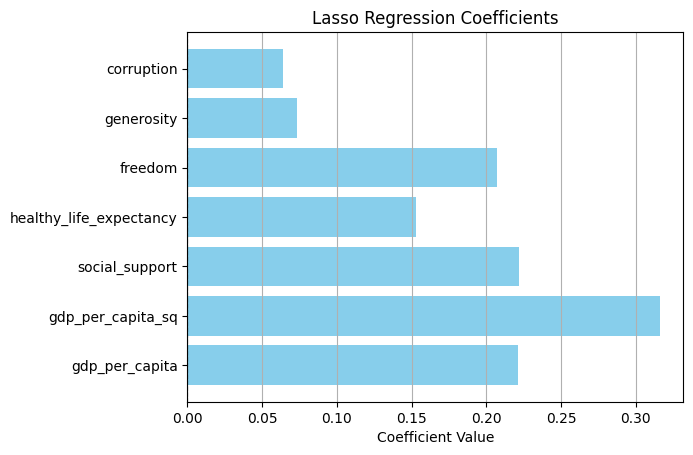

In [8]:
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso

# alpha 0.01
lasso = Lasso(alpha=0.01).fit(X_train_scaled, y_train)
notnull_lasso_coefs = (
pd.DataFrame(lasso.coef_, index=X_featnames,
columns=["coefficient"])
.loc[lambda x: x["coefficient"].round(2) != 0]
.round(3)
)
notnull_lasso_coefs

plt.barh(notnull_lasso_coefs.index,
notnull_lasso_coefs['coefficient'],
color='skyblue')
plt.xlabel('Coefficient Value')
plt.title('Lasso Regression Coefficients')
plt.axvline(0, color='black', linewidth=0.8,
linestyle='--') # Add a vertical line at zero
plt.grid(axis='x')
plt.show()

In [7]:
from sklearn.metrics import mean_squared_error
# Predicting on the test set
y_pred= lasso.predict(X_test_scaled)
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse

np.float64(0.5531535773498678)

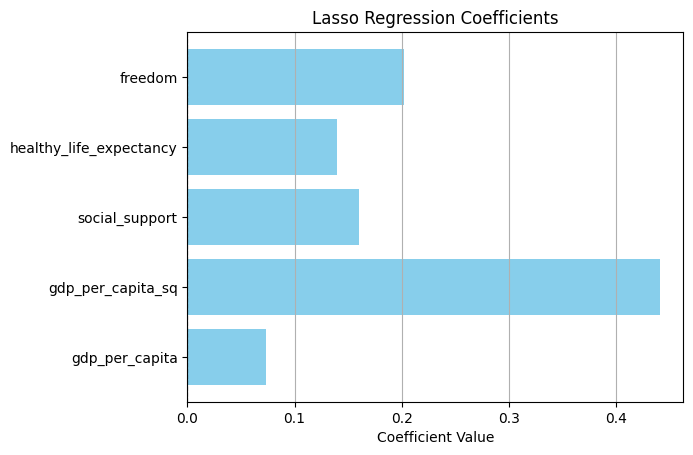

In [14]:
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso

# alpha = 0.1
lasso = Lasso(alpha=0.1).fit(X_train_scaled, y_train)
notnull_lasso_coefs = (
pd.DataFrame(lasso.coef_, index=X_featnames,
columns=["coefficient"])
.loc[lambda x: x["coefficient"].round(2) != 0]
.round(3)
)
notnull_lasso_coefs

plt.barh(notnull_lasso_coefs.index,
notnull_lasso_coefs['coefficient'],
color='skyblue')
plt.xlabel('Coefficient Value')
plt.title('Lasso Regression Coefficients')
plt.axvline(0, color='black', linewidth=0.8,
linestyle='--') # Add a vertical line at zero
plt.grid(axis='x')
plt.show()

In [15]:
from sklearn.metrics import mean_squared_error
# Predicting on the test set
y_pred= lasso.predict(X_test_scaled)
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse

np.float64(0.5953320744482788)

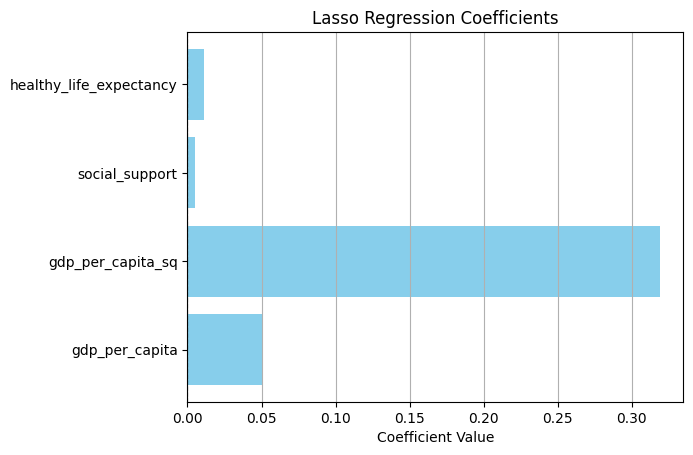

In [16]:
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso

# alpha = 0.5
lasso = Lasso(alpha=0.5).fit(X_train_scaled, y_train)
notnull_lasso_coefs = (
pd.DataFrame(lasso.coef_, index=X_featnames,
columns=["coefficient"])
.loc[lambda x: x["coefficient"].round(2) != 0]
.round(3)
)
notnull_lasso_coefs

plt.barh(notnull_lasso_coefs.index,
notnull_lasso_coefs['coefficient'],
color='skyblue')
plt.xlabel('Coefficient Value')
plt.title('Lasso Regression Coefficients')
plt.axvline(0, color='black', linewidth=0.8,
linestyle='--') # Add a vertical line at zero
plt.grid(axis='x')
plt.show()

In [17]:
from sklearn.metrics import mean_squared_error
# Predicting on the test set
y_pred= lasso.predict(X_test_scaled)
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse

np.float64(0.9000217486075643)

In [18]:
from sklearn.linear_model import LassoCV
lambdas = np.arange(0.01, 4.00, 0.01)
# Create and fit the LassoCV model
lasso_model = LassoCV(alphas=lambdas,cv=5,
random_state=42)
lasso_model.fit(X_train_scaled, y_train.values.ravel())

,eps,0.001
,n_alphas,'deprecated'
,alphas,"array([0.01, ..., 3.98, 3.99])"
,fit_intercept,True
,precompute,'auto'
,max_iter,1000
,tol,0.0001
,copy_X,True
,cv,5
,verbose,False
,n_jobs,None


In [19]:
lasso_coef = pd.DataFrame({"Feature": X_featnames,
"Coefficient": lasso_model.coef_})
not_null_lasso_coef = (
lasso_coef.loc[lambda x:
x["Coefficient"].round(3) != 0]
.round(3)
)
not_null_lasso_coef

,Feature,Coefficient
1,gdp_per_capita,0.221
2,gdp_per_capita_sq,0.316
3,social_support,0.222
4,healthy_life_expectancy,0.153
5,freedom,0.207
6,generosity,0.073
7,corruption,0.064


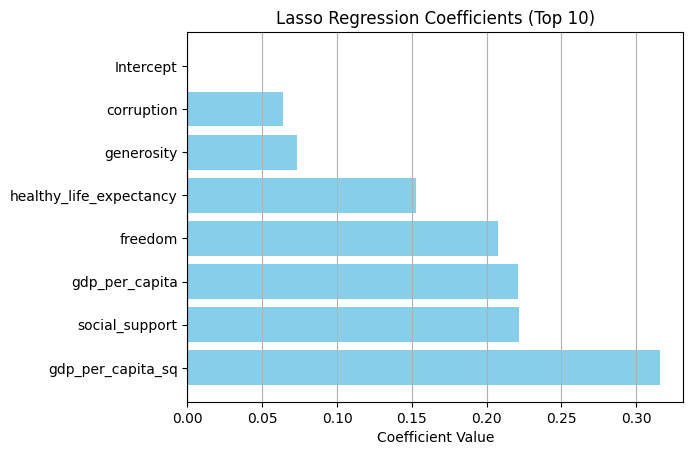

In [20]:
top_ten = lasso_coef.reindex(lasso_coef['Coefficient'].abs()
.nlargest(10).index)

plt.barh(top_ten['Feature'],
top_ten['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.title('Lasso Regression Coefficients (Top 10)')
plt.axvline(0, color='black', linewidth=0.8,
linestyle='--') # Add a vertical line at zero
plt.grid(axis='x')
plt.show()

In [21]:
rmse_lambda_folds = (
pd.DataFrame(lasso_model.mse_path_,
index=lambdas[::-1])
.apply(np.sqrt)
.mean(axis=1)
.to_frame(name="Test RMSE")
.round(2))
rmse_lambda_folds

,Test RMSE
3.99,1.11
3.98,1.11
3.97,1.11
3.96,1.11
3.95,1.11
...,...
0.05,0.56
0.04,0.56
0.03,0.56
0.02,0.55


In [22]:
rmse_lambda_folds.loc[lasso_model.alpha_]

Test RMSE    0.55
Name: 0.01, dtype: float64

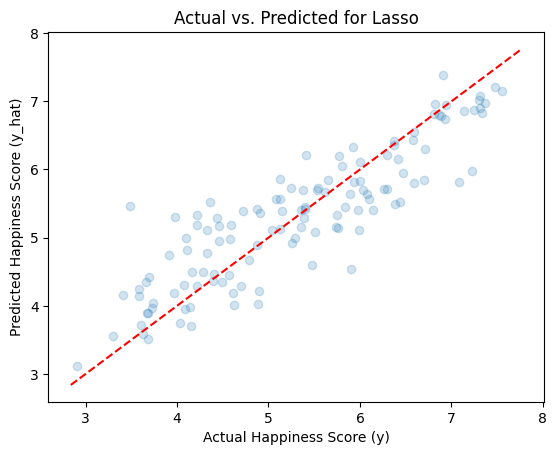

In [23]:
y_pred = lasso_model.predict(X_test_scaled)
plt.scatter(y_test, y_pred, alpha=0.2)
plt.plot([y.min(), y.max()], [y.min(), y.max()],
color='red', linestyle='--') # 45-degree line
plt.xlabel('Actual Happiness Score (y)')
plt.ylabel('Predicted Happiness Score (y_hat)')
plt.title('Actual vs. Predicted for Lasso')
plt.show()